In [1]:
!git clone -b features/split_dataset --single-branch https://github.com/hanvocado/pneumonia_detection.git
%cd pneumonia_detection
!git status
!git branch

Cloning into 'pneumonia_detection'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 91 (delta 29), reused 66 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 12.26 MiB | 38.50 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/pneumonia_detection
On branch features/split_dataset
Your branch is up to date with 'origin/features/split_dataset'.

nothing to commit, working tree clean
* features/split_dataset


In [2]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00


In [3]:
!jupyter nbconvert --to notebook --execute src/preprocess/download_and_preprocess.ipynb --output /content/out_download_and_preprocess.ipynb

[NbConvertApp] Converting notebook src/preprocess/download_and_preprocess.ipynb to notebook
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] Writing 6809213 bytes to /content/out_download_and_preprocess.ipynb


In [4]:
!jupyter nbconvert --to notebook --execute src/preprocess/split_dataset.ipynb \
  --output /content/out_split_dataset.ipynb

[NbConvertApp] Converting notebook src/preprocess/split_dataset.ipynb to notebook
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] Writing 1394371 bytes to /content/out_split_dataset.ipynb


In [5]:
!nvidia-smi

Tue Dec 16 09:26:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os, sys
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
import torch.nn.functional as F

In [18]:
# CẤU HÌNH & LOAD DỮ LIỆU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang chạy trên thiết bị: {device}")

current_directory = os.getcwd()
while not current_directory.endswith('pneumonia_detection'):
    current_directory = os.path.dirname(current_directory)
root_directory = current_directory
os.chdir(root_directory)
sys.path.insert(0, root_directory)
base_dir = os.path.join(root_directory, 'data_processed_new')

BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 10

Đang chạy trên thiết bị: cpu


In [20]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


try:
    train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=data_transforms)
    val_dataset   = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=data_transforms)
    test_dataset  = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Class mapping: {train_dataset.class_to_idx}")

except FileNotFoundError:
    print(f"LỖI: Không tìm thấy folder tại {base_dir}")

Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


In [21]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.flatten_size = 256 * 14 * 14

        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, self.flatten_size)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 26,080,450
Trainable parameters: 26,080,450


In [19]:
# VÒNG LẶP HUẤN LUYỆN
train_losses = []
val_losses = []
val_accuracies = []

# Best model tracking
best_val_acc = 0.0
best_model_path = "models/cnn_best.pth"
os.makedirs("models", exist_ok=True)

In [22]:
# VÒNG LẶP HUẤN LUYỆN
train_losses = []
val_losses = []
val_accuracies = []

# Best model tracking
best_val_acc = 0.0
best_model_path = "models/cnn_best.pth"
os.makedirs("models", exist_ok=True)

# Early stopping
epochs_without_improvement = 0

print("\nBẮT ĐẦU HUẤN LUYỆN MODEL")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE} epochs")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # --- TRAINING ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # VALIDATION
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    # Save best model and check early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | ✓ Best model saved!")
    else:
        epochs_without_improvement += 1
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | No improvement ({epochs_without_improvement}/{EARLY_STOPPING_PATIENCE})")

    # Early stopping check
    if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs (no improvement for {EARLY_STOPPING_PATIENCE} epochs)")
        break

total_time = (time.time() - start_time) / 60
print(f"\n Đã huấn luyện xong trong {total_time:.2f} phút!")
print(f" Best validation accuracy: {best_val_acc:.2f}%")
print(f" Best model saved to: {best_model_path}")


BẮT ĐẦU HUẤN LUYỆN MODEL
Early stopping patience: 10 epochs
Epoch [1/50] | Train Loss: 1.3034 | Val Loss: 0.1784 | Val Acc: 93.61% | ✓ Best model saved!
Epoch [2/50] | Train Loss: 0.1553 | Val Loss: 0.2076 | Val Acc: 91.68% | No improvement (1/10)
Epoch [3/50] | Train Loss: 0.1502 | Val Loss: 0.1492 | Val Acc: 94.41% | ✓ Best model saved!
Epoch [4/50] | Train Loss: 0.1377 | Val Loss: 0.1792 | Val Acc: 94.07% | No improvement (1/10)
Epoch [5/50] | Train Loss: 0.1276 | Val Loss: 0.1589 | Val Acc: 93.73% | No improvement (2/10)
Epoch [6/50] | Train Loss: 0.1231 | Val Loss: 0.2144 | Val Acc: 94.07% | No improvement (3/10)
Epoch [7/50] | Train Loss: 0.1335 | Val Loss: 0.1941 | Val Acc: 94.30% | No improvement (4/10)
Epoch [8/50] | Train Loss: 0.1285 | Val Loss: 1.4245 | Val Acc: 63.40% | No improvement (5/10)
Epoch [9/50] | Train Loss: 0.1156 | Val Loss: 0.2866 | Val Acc: 89.40% | No improvement (6/10)
Epoch [10/50] | Train Loss: 0.1055 | Val Loss: 0.1635 | Val Acc: 95.32% | ✓ Best model s

In [ ]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

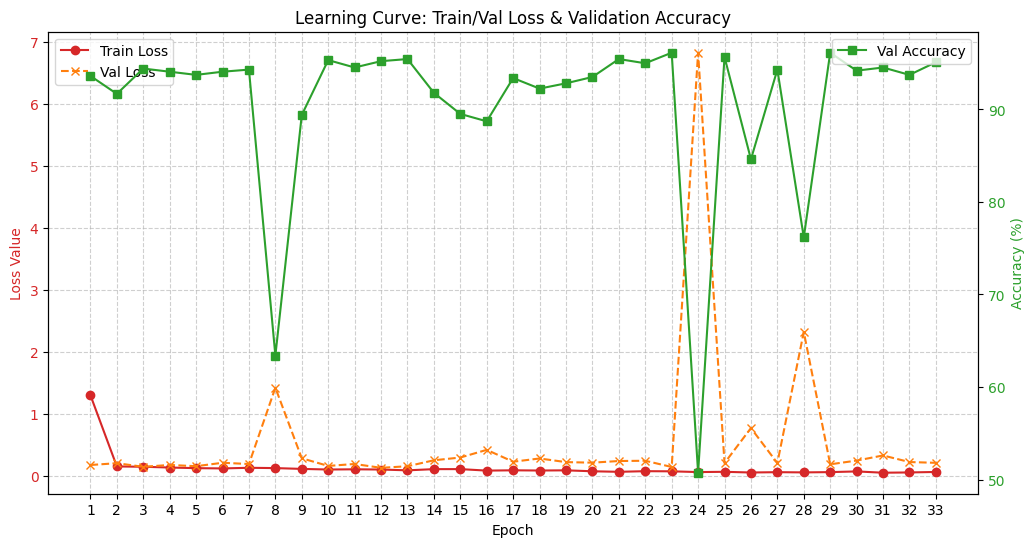

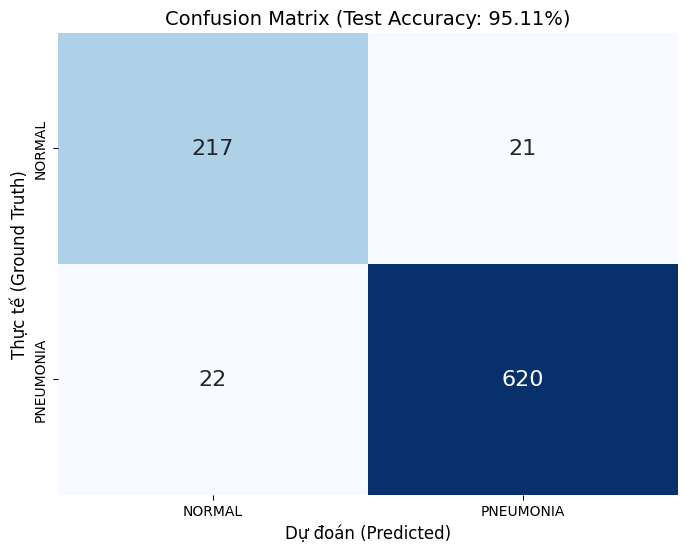

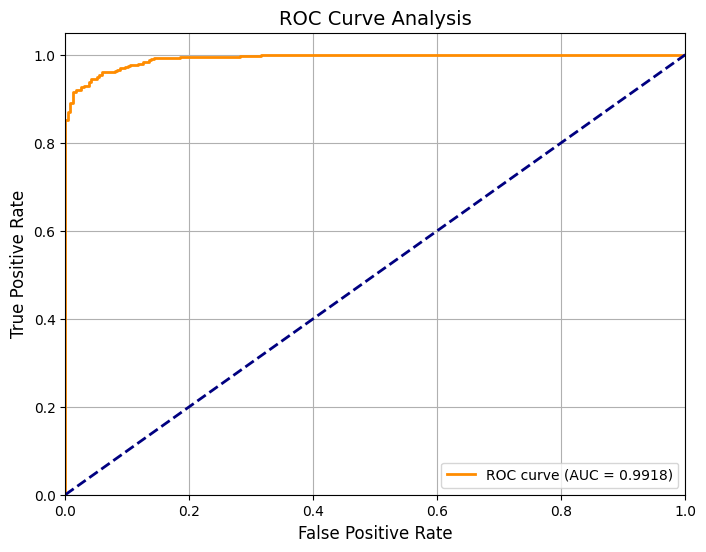


BÁO CÁO HIỆU SUẤT MODEL
              precision    recall  f1-score   support

      NORMAL       0.91      0.91      0.91       238
   PNEUMONIA       0.97      0.97      0.97       642

    accuracy                           0.95       880
   macro avg       0.94      0.94      0.94       880
weighted avg       0.95      0.95      0.95       880

----------------------------------------
AUC Score: 0.9918
False Negatives (Sót bệnh): 22 ca
False Positives (Báo nhầm): 21 ca


In [24]:
def evaluate_and_visualize(model, loader, device, train_losses, val_losses, val_accuracies):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    # Tính toán chỉ số
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    report = classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA'])
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # BIỂU ĐỒ 1: LEARNING CURVE
    epochs_range = range(1, len(train_losses) + 1)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value', color=color)

    ax1.plot(epochs_range, train_losses, color=color, marker='o', label='Train Loss')
    ax1.plot(epochs_range, val_losses, color='tab:orange', marker='x', linestyle='--', label='Val Loss')

    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_xticks(epochs_range)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(epochs_range, val_accuracies, color=color, marker='s', label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('Learning Curve: Train/Val Loss & Validation Accuracy')
    plt.show()

    # BIỂU ĐỒ 2: CONFUSION MATRIX
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'], annot_kws={"size": 16})
    plt.xlabel('Dự đoán (Predicted)', fontsize=12)
    plt.ylabel('Thực tế (Ground Truth)', fontsize=12)
    plt.title(f'Confusion Matrix (Test Accuracy: {(tp+tn)/(tp+tn+fp+fn):.2%})', fontsize=14)
    plt.show()

    # BIỂU ĐỒ 3: ROC CURVE
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve Analysis', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print("\n" + "="*40)
    print("BÁO CÁO HIỆU SUẤT MODEL")
    print("="*40)
    print(report)
    print("-" * 40)
    print(f"AUC Score: {roc_auc:.4f}")
    print(f"False Negatives (Sót bệnh): {fn} ca")
    print(f"False Positives (Báo nhầm): {fp} ca")
    print("="*40)

evaluate_and_visualize(model, test_loader, device, train_losses, val_losses, val_accuracies)